In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

In [2]:

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/noisyloss/')

# Import your custom loss functions
import loss_functions


Mounted at /content/drive


In [26]:


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [27]:




# Define the CNN model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 5 * 5, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract data and labels
x_train = train_dataset.data.numpy().astype('float32') / 255.0
y_train = train_dataset.targets.numpy()
x_test = test_dataset.data.numpy().astype('float32') / 255.0
y_test = test_dataset.targets.numpy()

# Reshape data
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)


In [35]:


# Add noisy labels
NOISE_LEVEL = 0.4
perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])
noise = perm[y_train]

In [36]:



if NOISE_LEVEL > 0:
    _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                    test_size=NOISE_LEVEL,
                                                    random_state=42).split(x_train, y_train)))
    y_train_noise = y_train.copy()
    y_train_noise[noise_idx] = noise[noise_idx]

    train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                              random_state=42).split(x_train, y_train_noise)))

    X_train_train = x_train[train_idx]
    y_train_correct = y_train[train_idx]
    y_train_train = y_train_noise[train_idx]
    X_train_val = x_train[val_idx]
    y_train_val = y_train_noise[val_idx]
    y_train_val_correct = y_train[val_idx]
else:
    train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                              random_state=42).split(x_train, y_train)))
    X_train_train = x_train[train_idx]
    y_train_train = y_train[train_idx]
    y_train_correct = y_train[train_idx]
    X_train_val = x_train[val_idx]
    y_train_val = y_train[val_idx]
    y_train_val_correct = y_train[val_idx]

# Convert to PyTorch tensors
X_train_train = torch.FloatTensor(X_train_train)
y_train_train = torch.LongTensor(y_train_train)
X_train_val = torch.FloatTensor(X_train_val)
y_train_val_correct = torch.LongTensor(y_train_val_correct)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_train, y_train_train)
val_dataset = TensorDataset(X_train_val, y_train_val_correct)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


In [37]:

# Initialize model
model = MNISTModel().to(device)
optimizer = optim.Adam(model.parameters())

In [38]:

# Use MAE loss - MUST apply softmax to convert logits to probabilities
def mae_loss_multi_class(outputs, targets):
    """
    Mean Absolute Error loss for multi-class classification.
    Converts logits to probabilities via softmax, then computes MAE against one-hot targets.
    """
    num_classes = outputs.size(1)
    # Convert logits to probabilities using softmax
    probs = torch.nn.functional.softmax(outputs, dim=1)
    # Convert targets to one-hot encoding
    targets_one_hot = torch.zeros_like(probs)
    targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
    # Compute MAE between probabilities and one-hot targets
    return torch.mean(torch.abs(probs - targets_one_hot))

In [39]:

criterion = mae_loss_multi_class

In [40]:


# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return running_loss / len(loader), correct / total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return running_loss / len(loader), correct / total

# Training loop with early stopping
epochs = 10
patience = 4
best_val_loss = float('inf')
patience_counter = 0

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

acc = metrics.accuracy_score(y_true, y_pred)
macro_averaged_f1 = metrics.f1_score(y_true, y_pred, average='macro')
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1: {macro_averaged_f1:.4f}")


Epoch 1/10
Train Loss: 0.1267, Train Acc: 0.3896
Val Loss: 0.0537, Val Acc: 0.7422
Epoch 2/10
Train Loss: 0.1017, Train Acc: 0.4976
Val Loss: 0.0488, Val Acc: 0.7612
Epoch 3/10
Train Loss: 0.0967, Train Acc: 0.5216
Val Loss: 0.0459, Val Acc: 0.7748
Epoch 4/10
Train Loss: 0.0945, Train Acc: 0.5315
Val Loss: 0.0446, Val Acc: 0.7802
Epoch 5/10
Train Loss: 0.0933, Train Acc: 0.5367
Val Loss: 0.0441, Val Acc: 0.7818
Epoch 6/10
Train Loss: 0.0927, Train Acc: 0.5395
Val Loss: 0.0432, Val Acc: 0.7867
Epoch 7/10
Train Loss: 0.0921, Train Acc: 0.5415
Val Loss: 0.0428, Val Acc: 0.7888
Epoch 8/10
Train Loss: 0.0919, Train Acc: 0.5427
Val Loss: 0.0426, Val Acc: 0.7883
Epoch 9/10
Train Loss: 0.0914, Train Acc: 0.5449
Val Loss: 0.0423, Val Acc: 0.7905
Epoch 10/10
Train Loss: 0.0913, Train Acc: 0.5459
Val Loss: 0.0420, Val Acc: 0.7915
Test Accuracy: 0.7963
Test Macro F1: 0.7242


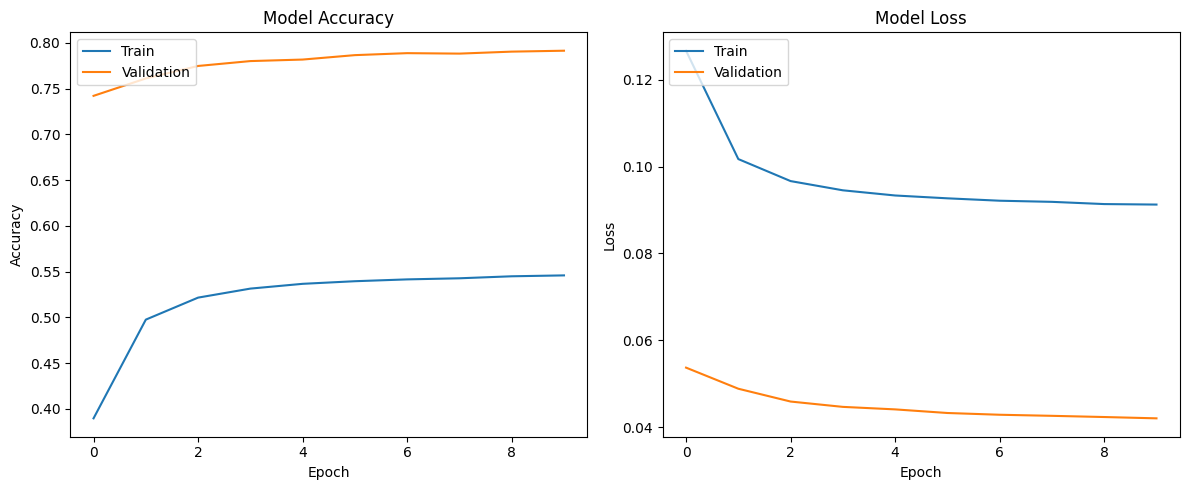

Noise Level: 0.4


In [41]:

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

print(f"Noise Level: {NOISE_LEVEL}")

In [42]:
print(NOISE_LEVEL)

0.4
